In [1]:
# IMPORTS
import numpy as np
from scipy.sparse import coo_matrix, eye
import scipy.linalg as sla
from scipy.linalg import norm

In [2]:
#FUNCTION DEFINITIONS

#Local function to compute the difference matrices of anu order
def diff_mat(n,order):
    #Zero'th derivative
    if order==0:
        D = eye(n)
    else:
        #Compute D of specific order
        c = np.array([-1,1] + [0] * (order-1))

        nd = n-order
        for i in range(1,order):
            c = np.append(0,c[0:order]) - np.append(c[0:order],0)

        D = coo_matrix((nd, n), dtype=np.int8)

        for i in range(0,order+1):
            row = np.array(range(nd))
            col = np.array(range(nd)) + i
            val = c[i] * np.ones(nd)
            D = D + coo_matrix((val, (row, col)), shape=(nd, n))

    return D

def menger(P1, P2, P3):
    
    u = P1 - P2
    v = P3 - P2

    return 2 * (v[0] * u[1] - u[0] * v[1]) / ( norm(u) * norm(v) * norm(u - v) )

def check_lambdas(lambda_min, lambda_max, y, order = 3, tol = 1e-8):
    
    n = len(y)
    
    D = diff_mat(n, order)
    
    beta_min = trend_filter(y, lambd = lambda_min, order = order)
    residual_min = norm(y - beta_min)
    beta_max = trend_filter(y, lambd = lambda_max, order = order)
    reg_residual_min = norm(D * beta_max, ord = 1)
        
    while residual_min < tol:
        lambda_min = lambda_min * 10
        beta_min = trend_filter(y, lambd = lambda_min, order = order)
        residual_min = norm(y - beta_min)
        reg_residual_max = norm(D * beta_min, ord = 1)

    while reg_residual_min < tol:
        lambda_max = lambda_max / 10
        beta_max = trend_filter(y, lambd = lambda_max, order = order)
        residual_max = norm(y - beta_max)
        reg_residual_min = norm(D * beta_max, ord = 1)
    
    #Compute normalization coefficients to transform the L-curve into a [-1, 1] range
    cres0 = 1 - 2/(np.log(residual_max) - np.log(residual_min)) * np.log(residual_max)
    cres1 = 2 / (np.log(residual_max) - np.log(residual_min));
    creg0 = 1 - 2/(np.log(reg_residual_max) - np.log(reg_residual_min)) * np.log(reg_residual_max)
    creg1 = 2 / (np.log(reg_residual_max) - np.log(reg_residual_min))
    
    normalization_coefs = [(cres0, cres1),(creg0, creg1)]
        
    return (lambda_max, lambda_min, normalization_coefs)

def normalize_lcurve(residual, reg_residual, normalization_coefs):
    
    #Unpack coefficients
    cres0, cres1 = normalization_coefs[0]
    creg0, creg1 = normalization_coefs[1]
    
    xi = cres0 + cres1 * np.log(residual)
    eta = creg0 + creg1 * np.log(reg_residual)
    
    return (xi, eta)

In [3]:
def trend_filter(y, lambd = 0, order = 3, verbose = False):
    
    """
    trend_filter(y, lambda = 0, order = 3)
    
    finds the solution of the l1 trend estimation problem
    
     minimize    (1/2)||y-x||^2+lambda*||Dx||_1,
    
    with variable x, and problem data y and lambda, with lambda >0.
    D is the second difference matrix, with rows [0... -1 2 -1 ...0]
    
    and the dual problem
    
     minimize    (1/2)||D'*z||^2-y'*D'*z
     subject to  norm(z,inf) <= lambda,
    
    with variable z.
    
    Input arguments:
    
     - y:          n-vector; original signal
     - lambda:     scalar; positive regularization parameter
     - order:      scalar: order of the difference matrices
    
    Output arguments:
    
     - x:          n-vector; primal optimal point
    
    Adaptation from
    "l1 Trend Filtering", S. Kim, K. Koh, ,S. Boyd and D. Gorinevsky
    www.stanford.edu/~boyd/l1_trend_filtering.html
    
    Author: Alexandre Cortiella
    Affiliation: University of Colorado Boulder
    Department: Aerospace Engineering Sciences
    Date: 11/09/2020
    Version: v1.0
    Updated: 11/09/2020
    
    """
    
    # PARAMETERS
    alpha = 0.01 #backtracking linesearch parameter (0,0.5]
    beta = 0.5 # backtracking linesearch parameter (0,1)
    mu = 2 # IPM parameter: t update
    max_iter = 40 # IPM parameter: max iteration of IPM
    max_ls_iter = 20 # IPM parameter: max iteration of line search
    tol = 1e-4 # IPM parameter: tolerance

    itr = 0
    gap = 1

    # DIMENSIONS
    n   = len(y) #length of signal x

    # OPERATOR MATRICES
    D = diff_mat(n,order)

    DDT = D * D.T
    Dy = D * y

    m = len(Dy)

    # VARIABLES
    z   = np.zeros(m) # dual variable
    mu1 = np.ones(m) # dual of dual variable
    mu2 = np.ones(m) # dual of dual variable

    t = 1e-10; 
    p_obj =  float('inf')
    d_obj =  0
    step =  float('inf')
    f1   =  z - lambd
    f2   = - z - lambd
    if verbose:
        print(f'Iteration   Primal obj.    Dual obj.     Gap')
        print('\n')
    
    #----------------------------------------------------------------------
    #               MAIN LOOP
    #----------------------------------------------------------------------

    for iters in range(max_iter):

        DTz = (z.T * D).T
        DDTz = D * DTz

        w = Dy - (mu1 - mu2)

        # two ways to evaluate primal objective:
        # 1) using dual variable of dual problem
        # 2) using optimality condition    
        #temp = lsqr(DDT, w)[0] Not comparable to backslash in matlab (unstable)
        #temp = nla.lstsq(DDT.todense(), w)[0] # numpy library (similar results as scipy)

        temp = sla.lstsq(DDT.todense(), w)[0] #may be an overkill but stable
        p_obj1 = 0.5 * np.dot(w,temp) + lambd * np.sum(mu1 + mu2)
        p_obj2 = 0.5 * np.dot(DTz.T, DTz) + lambd * np.sum(np.abs(Dy - DDTz))

        p_obj = np.min([p_obj1, p_obj2])
        d_obj = -0.5 * np.dot(DTz, DTz) + np.dot(Dy.T, z)

        gap  =  p_obj - d_obj
        
        if verbose:
            print("{0:6d} {1:15.4e} {2:13.5e} {3:10.2e}".format(iters, p_obj, d_obj, gap))
        #Check stopping criterion
        if gap <= tol:
            status = 'solved'
            if verbose:
                print(status)
            x = y - D.T * z

            #return x
            break

        if step >= 0.2:
            t = np.max([2 * m * mu / gap, 1.2 * t])

        # CALCULATE NEWTON STEP

        rz = DDTz - w

        val = mu1 / f1 + mu2 / f2
        row = np.arange(m)
        col = np.arange(m)

        S = DDT - coo_matrix((val, (row, col)), shape = (m,m))
        r = - DDTz + Dy + ( 1 / t ) / f1 - ( 1 / t ) / f2

        dz      =  sla.lstsq(S.todense(), r)[0]
        dmu1    = - ( mu1 + ( (1 / t) + dz * mu1 ) / f1 )
        dmu2    = - ( mu2 + ( ( 1 / t ) - dz * mu2 ) / f2 )

        resDual = rz
        resCent = np.concatenate([- mu1 * f1 - 1 / t, - mu2 * f2 - 1 / t])
        residual= np.concatenate([resDual, resCent])

        # BACKTRACKING LINESEARCH
        negIdx1 = (dmu1 < 0)
        negIdx2 = (dmu2 < 0)
        step = 1

        if any(negIdx1):
            step = np.min( [step, 0.99 * np.min( - mu1[negIdx1] / dmu1[negIdx1] )])
        if any(negIdx2):
            step = np.min( [step, 0.99 * np.min( - mu2[negIdx2] / dmu2[negIdx2] )])

        for liter in range(max_ls_iter):

            newz = z  + step * dz
            newmu1 = mu1 + step * dmu1
            newmu2 = mu2 + step * dmu2
            newf1 = newz - lambd
            newf2 = - newz - lambd

            # UPDATE RESIDUAL
            newResDual = DDT * newz - Dy + newmu1 - newmu2
            newResCent = np.concatenate([- newmu1 * newf1 - 1 / t, - newmu2 * newf2 - 1 / t])
            newResidual = np.concatenate([newResDual, newResCent])

            if ( np.max([np.max(newf1), np.max(newf2)]) < 0 ) and ( norm(newResidual) <= (1 - alpha * step) * norm(residual) ):
                break

            step = beta * step

        # UPDATE PRIMAL AND DUAL VARIABLES
        z  = newz
        mu1 = newmu1
        mu2 = newmu2
        f1 = newf1
        f2 = newf2

    # The solution may be close at this point, but does not meet the stopping
    # criterion (in terms of duality gap).
    x = y - D.T * z
    if (iters >= max_iter):
        status = 'maxiter exceeded'
        if verbose:
            print(status)
        
    return x

In [6]:
def lcurve_corner_tf(y, order = 3, lambda_max = 1e10, lambda_min = 1e-10, epsilon = 0.001, max_iter = 50, normalize = True, verbose = False):
    
    n = len(y)
    pGS = (1 + np.sqrt(5))/2 #Golden search parameter
    gap = 1
    itr = 0
    lambda_itr = []

    #Check the range of lambdas and compute normalization coefficients
    lambda_max, lambda_min, normalization_coefs = check_lambdas(lambda_min, lambda_max, y)

    lambda_vec = np.array([lambda_min, lambda_max, 0, 0])
    lambda_vec[2] = np.exp( (np.log(lambda_vec[1]) + pGS * np.log(lambda_vec[0])) / (1 + pGS) ) 
    lambda_vec[3] = np.exp( np.log(lambda_vec[0]) + np.log(lambda_vec[1]) - np.log(lambda_vec[2]) )

    residuals = np.zeros(4)
    reg_residuals = np.zeros(4)
    lc_res = []
    lc_reg = []
    
    D = diff_mat(n,order)


    while (gap >= epsilon) and (itr <= max_iter):

        if itr == 0:

            for s in range(4):

                current_lambda = lambda_vec[s]

                #Run trend filter with current lambda

                beta = trend_filter(y, lambd = current_lambda, order = order)

                residuals[s] = norm(y - beta)
                reg_residuals[s] = norm(D * beta, ord = 1)

            #Normalize between -1 and 1
            xis, etas = normalize_lcurve(residuals, reg_residuals, normalization_coefs)
            
            if normalize:
                lc_res.append(xis)
                lc_reg.append(etas)
            else:
                lc_res.append(np.log(residuals))
                lc_reg.append(np.log(reg_residuals))

            P = np.array([[xis[0],xis[1],xis[2],xis[3]], [etas[0],etas[1],etas[2],etas[3]]])           
            indx = np.argsort(lambda_vec)

            #Sort lambdas
            lambda_vec = lambda_vec[indx]
            P = P[:,indx]

        # Compute curvatures of the current points
        C2 = menger(P[:,0], P[:,1], P[:,2])
        C3 = menger(P[:,1], P[:,2], P[:,3])

        # Check if the curvature is negative and update values
        while C3 < 0:

            #Reassign maximum and interior lambdas and Lcurve points (Golden search interval)
            lambda_vec[3] = lambda_vec[2]
            P[:,3] = P[:,2]
            lambda_vec[2] = lambda_vec[1]
            P[:,2] = P[:,1]

            #Update interior lambda and interior point
            lambda_vec[1] = np.exp( (np.log(lambda_vec[3]) + pGS * np.log(lambda_vec[0])) / (1 + pGS) ) 

            beta = trend_filter(y, lambd = lambda_vec[1], order = order)

            residual = norm(y - beta)
            reg_residual = norm(D * beta, ord = 1)

            #Normalize between -1 and 1
            xi, eta = normalize_lcurve(residual, reg_residual, normalization_coefs)

            P[:,1] = [xi,eta]

            C3 = menger(P[:,1], P[:,2], P[:,3])

        # Update values depending on the curvature at the new points
        if C2 > C3:

            current_lambda = lambda_vec[1]

            #Reassign maximum and interior lambdas and Lcurve points (Golden search interval)
            lambda_vec[3] = lambda_vec[2]
            P[:,3] = P[:,2]

            lambda_vec[2] = lambda_vec[1]
            P[:,2] = P[:,1]

            #Update interior lambda and interior point
            lambda_vec[1] = np.exp( (np.log(lambda_vec[3]) + pGS * np.log(lambda_vec[0])) / (1 + pGS) ) 

            beta = trend_filter(y, lambd = lambda_vec[1], order = order)

            residual = norm(y - beta)
            reg_residual = norm(D * beta, ord = 1)

            #Normalize between -1 and 1
            xi, eta = normalize_lcurve(residual, reg_residual, normalization_coefs)

            P[:,1] = [xi,eta]

        else:

            current_lambda = lambda_vec[2]

            #Reassign maximum and interior lambdas and Lcurve points (Golden search interval)
            lambda_vec[0] = lambda_vec[1]
            P[:,0] = P[:,1]

            lambda_vec[1] = lambda_vec[2]
            P[:,1] = P[:,2]

            #Update interior lambda and interior point
            lambda_vec[2] = np.exp( np.log(lambda_vec[0]) + np.log(lambda_vec[3]) - np.log(lambda_vec[1]) )

            beta = trend_filter(y, lambd = lambda_vec[2], order = order)

            residual = norm(y - beta)            
            reg_residual = norm(D * beta, ord = 1)

            #Normalize between -1 and 1
            xi, eta = normalize_lcurve(residual, reg_residual, normalization_coefs)

            P[:,2] = [xi,eta]

        gap = ( lambda_vec[3] - lambda_vec[0] ) / lambda_vec[3]

        if gap < epsilon:
            print(f'  Convergence criterion reached in {itr} iterations.')

        lambda_itr.append(current_lambda)

        if normalize:
            lc_res.append(xi)
            lc_reg.append(eta)
        else:
            lc_res.append(np.log(residual))
            lc_reg.append(np.log(reg_residual))

        itr += 1

        if itr == max_iter:
            print(f'  Maximum number of {itr} iterations reached.')

    #Solve for optimal lambda
    beta = trend_filter(y, lambd = current_lambda, order = order)
    
    return (beta, [lc_res, lc_reg], lambda_itr)

def full_lcurve(y, order = 3, lambda_max = 1e10, lambda_min = 1e-10, n_lambdas = 100, normalize = False):
    
    n = len(y)
    residual_lc = np.zeros(n_lambdas)
    reg_residual_lc = np.zeros(n_lambdas)
    
    #Check range of lambdas and compute normalization coefficients
    lambda_max, lambda_min, normalization_coefs = check_lambdas(lambda_min, lambda_max, y, order, tol = 1e-8)
    
    #Generate array of lambdas
    lambdas = np.logspace(np.log(lambda_min), np.log(lambda_max), n_lambdas)
    
    D = diff_mat(n,order) 
    
    #Loop over lambdas
    for i, lambd in enumerate(lambdas):
    
        y_tf = trend_filter(y, lambd, order = 3)

        residual_lc[i] = norm(y - y_tf)
        reg_residual_lc[i] = norm(D * y_tf, ord = 1)
    
    if normalize:
        
        xi, eta = normalize_lcurve(residual_lc, reg_residual_lc, normalization_coefs)
        
        plt.plot(xi, eta)
        plt.xlabel(r'$||y - \beta||_2$')
        plt.ylabel(r'$||D^{0}\beta||_1$'.format(order))
        
        return (xi, eta)
    
    else:
        
        plt.loglog(residual_lc, reg_residual_lc)
        plt.xlabel(r'$||y - \beta||_2$')
        plt.ylabel(r'$||D^{0}\beta||_1$'.format(order))
    
        return (residual_lc, reg_residual_lc)



In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

t = np.linspace(0,10,101)
m_samp = len(t)
x = np.sin(t)

sigma = 0.1
y = x + sigma * np.random.randn(m_samp)
lambdas = np.logspace(-8,8,100)

y_tf = np.zeros((m_samp,len(lambdas)))
error_y = np.zeros(len(lambdas))
residual_lc = np.zeros(len(lambdas))
reg_residual_lc = np.zeros(len(lambdas))

D3 = diff_mat(m_samp,order = 3)

for i, lambd in enumerate(lambdas):
    
    y_tf[:,i] = trend_filter(y, lambd, order = 3)
    
    residual_lc[i] = norm(y - y_tf[:,i])
    reg_residual_lc[i] = norm(D3 * y_tf[:,i], ord = 1)
    error_y[i] = norm(y_tf[:,i] - x)

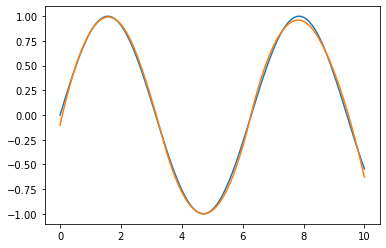

In [8]:
lambda_min_indx = np.argmin(error_y)


# plt.plot(t,y,'r.')
plt.plot(t,x)
plt.plot(t,y_tf[:,lambda_min_indx])

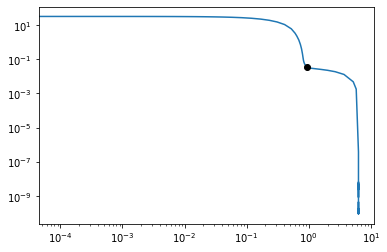

In [9]:
plt.loglog(residual_lc,reg_residual_lc)
plt.loglog(residual_lc[lambda_min_indx],reg_residual_lc[lambda_min_indx],'ko')

In [10]:
beta, lcurve_data = lcurve_corner_tf(y)[0:2]

  Convergence criterion reached in 19 iterations.


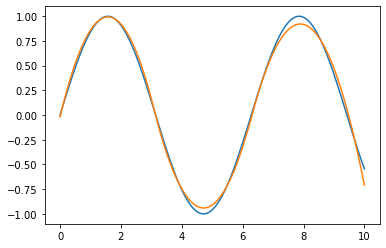

In [27]:
plt.plot(t,x)
plt.plot(t,beta)

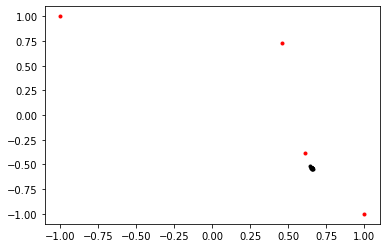

In [28]:

plt.plot(lcurve_data[0][0],lcurve_data[1][0],'r.')
plt.plot(lcurve_data[0][1:],lcurve_data[1][1:],'k.')


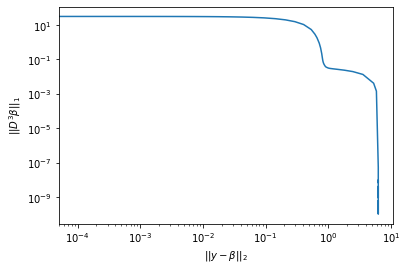

In [11]:
xi, eta = full_lcurve(y, n_lambdas = 100, normalize = False)